In [1]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn import linear_model
# from scipy import signal
# from scipy.stats import entropy
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('seaborn-poster')
import datetime

from multiprocessing import Pool
from itertools import repeat

In [2]:
plt.style.use('seaborn-poster')

In [3]:
def data_generator(ts_length = 400, 
                   random_seed = None, 
                   cp_prob = 1, 
                   is_multiplicative = False, 
                   is_trend = False, 
                   change_type = 'mean',
                   change_point = 352):
    if random_seed:
        np.random.seed(random_seed)
    
    signal_period = (1.05*np.cos((2*np.pi*np.arange(0, ts_length))/24 + (3*np.pi)/4) + 
                    0.82*np.cos((2*np.pi*np.arange(0, ts_length))/12 + np.pi/12) + 
                    0.27*np.cos((2*np.pi*np.arange(0, ts_length))/8 - (2*np.pi/3)) + 
                    0.05*np.cos((2*np.pi*np.arange(0, ts_length))/6 - np.pi/3))    
    
    if is_trend:
        trend_a = np.random.normal(0,0.005,1)
    else:    
        trend_a = 0
    signal_trend = trend_a*np.arange(1, ts_length+1)
    noise = np.random.normal(0,0.10,ts_length)
    signal = signal_trend+signal_period+noise

    change_point = np.random.choice([None,change_point],1,p=[1-cp_prob,cp_prob])[0]
    
    if change_type=='mean':
        change_point_value = np.random.normal(0,0.2,1)*np.random.choice([-1,1],1,)[0]
        while abs(change_point_value) <= 0.3:
            change_point_value = np.random.normal(0,0.2,1)*np.random.choice([-1,1],1,)[0]
        if change_point:
            signal[change_point:] = signal[change_point:]+change_point_value
        else:
            change_point_value = None
    elif change_type=='trend':
        
        trend_change = np.random.normal(0,0.005,1)
        while abs(trend_change - trend_a) <= 0.005:
            trend_change = np.random.normal(0,0.005,1)
        if change_point:
            change_point_value = signal_trend[change_point-1] + trend_change*np.arange(1, ts_length-change_point+1)
            signal[change_point:] = signal[change_point:] - signal_trend[change_point:] + change_point_value
        else:
            change_point_value = None
        
    elif change_type=='local':
        change_point_value = np.random.normal(0,1,1)*np.random.choice([-1,1],1,)[0]
        while abs(change_point_value <= 0.5):
            change_point_value = np.random.normal(0,1,1)*np.random.choice([-1,1],1,)[0]
        if change_point:
            signal[change_point] = signal[change_point]+change_point_value
        else:
            change_point_value = None
    else:
        raise ValueError("Wrong change point type")
    
    if is_multiplicative:
        signal = np.exp(signal)
    return([signal, change_point, change_point_value])


def sliding_window(data, size, stepsize=1, padded=False, axis=-1, copy=True):
    """
    Calculate a sliding window over a signal
    Parameters
    ----------
    data : numpy array
        The array to be slided over.
    size : int
        The sliding window size
    stepsize : int
        The sliding window stepsize. Defaults to 1.
    axis : int
        The axis to slide over. Defaults to the last axis.
    copy : bool
        Return strided array as copy to avoid sideffects when manipulating the
        output array.
    Returns
    -------
    data : numpy array
        A matrix where row in last dimension consists of one instance
        of the sliding window.
    Notes
    -----
    - Be wary of setting `copy` to `False` as undesired sideffects with the
      output values may occurr.
    Examples
    --------
    >>> a = numpy.array([1, 2, 3, 4, 5])
    >>> sliding_window(a, size=3)
    array([[1, 2, 3],
           [2, 3, 4],
           [3, 4, 5]])
    >>> sliding_window(a, size=3, stepsize=2)
    array([[1, 2, 3],
           [3, 4, 5]])
    See Also
    --------
    pieces : Calculate number of pieces available by sliding
    """
    if axis >= data.ndim:
        raise ValueError(
            "Axis value out of range"
        )

    if stepsize < 1:
        raise ValueError(
            "Stepsize may not be zero or negative"
        )

    if size > data.shape[axis]:
        raise ValueError(
            "Sliding window size may not exceed size of selected axis"
        )

    shape = list(data.shape)
    shape[axis] = np.floor(data.shape[axis] / stepsize - size / stepsize + 1).astype(int)
    shape.append(size)

    strides = list(data.strides)
    strides[axis] *= stepsize
    strides.append(data.strides[axis])

    strided = np.lib.stride_tricks.as_strided(
        data, shape=shape, strides=strides
    )

    if copy:
        return strided.copy()
    else:
        return strided
    
    
def approximation_mean(time_series, window, threshold=None):
    
    if window%2 != 0:
        window += 1
    if len(time_series) < window:
        raise ValueError("Time series has to be not shorter than window size")
    half_window = int(window/2)
    result = [np.nan]*(window-1)
    norm = np.sum((time_series[0:window] - np.mean(time_series[0:window]))**2)+1
#     print(norm)
#     print(time_series)
    all_ts_mean = np.convolve(time_series, np.ones((window,))/window, mode='valid')
    all_ts_slides = sliding_window(time_series, window)
    all_ts_cost = np.sum((all_ts_slides - all_ts_mean[:,None])**2,axis=1)
    
    left_right_ts_mean = np.convolve(time_series, np.ones((half_window,))/half_window, mode='valid')
    left_right_ts_slides = sliding_window(time_series, half_window)
    left_ts_cost = np.sum((left_right_ts_slides[:-half_window,:] - left_right_ts_mean[:-half_window,None])**2,axis=1)
    right_ts_cost = np.sum((left_right_ts_slides[half_window:,:] - left_right_ts_mean[half_window:,None])**2,axis=1)
    
    
    result.extend(list((all_ts_cost - left_ts_cost - right_ts_cost)/norm))
        
    return(result)

def prediction_mean(time_series, window):
    if window%2 != 0:
        window += 1
    if len(time_series) < window:
        raise ValueError("Time series has to be not shorter than window size")
    half_window = int(window/2)
    result = [np.nan]*(window-1)
    norm = np.sum((time_series[half_window:window] - np.mean(time_series[0:half_window]))**2)+1
    
    left_right_ts_mean = np.convolve(time_series, np.ones((half_window,))/half_window, mode='valid')
    left_right_ts_slides = sliding_window(time_series, half_window)
    
    right_ts_cost = np.sum((left_right_ts_slides[half_window:,:] - left_right_ts_mean[:-half_window,None])**2,axis=1)
    result.extend(list(right_ts_cost)/norm)

    return(result)


def get_model_trend_X(time_series):
    ts_length = len(time_series)
#     X = np.array([x for x in range(0,ts_length)]).reshape([ts_length,1])
    X = np.hstack((
        np.array([1 for x in range(0,ts_length)]).reshape([ts_length,1]),
        np.array([x for x in range(0,ts_length)]).reshape([ts_length,1])
              ))
    return X

def get_model_sin_X(time_series):
    ts_length = len(time_series)
    X = np.hstack((
        np.array([x for x in range(0,ts_length)]).reshape([ts_length,1]),
        np.cos(np.array([(2*np.pi*x)/24 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.sin(np.array([(2*np.pi*x)/24 for x in range(0,ts_length)])).reshape([ts_length,1]) #,
#         np.cos(np.array([(2*np.pi*x)/12 for x in range(0,ts_length)])).reshape([ts_length,1]),
#         np.sin(np.array([(2*np.pi*x)/12 for x in range(0,ts_length)])).reshape([ts_length,1]),
#         np.cos(np.array([(2*np.pi*x)/8 for x in range(0,ts_length)])).reshape([ts_length,1]),
#         np.sin(np.array([(2*np.pi*x)/8 for x in range(0,ts_length)])).reshape([ts_length,1]),
#         np.cos(np.array([(2*np.pi*x)/6 for x in range(0,ts_length)])).reshape([ts_length,1]),
#         np.sin(np.array([(2*np.pi*x)/6 for x in range(0,ts_length)])).reshape([ts_length,1])
              ))
    return X

def get_model_sin_insight_X(time_series):
    ts_length = len(time_series)
    X = np.hstack((
        np.array([x for x in range(0,ts_length)]).reshape([ts_length,1]),
        np.cos(np.array([(2*np.pi*x)/24 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.sin(np.array([(2*np.pi*x)/24 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.cos(np.array([(2*np.pi*x)/12 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.sin(np.array([(2*np.pi*x)/12 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.cos(np.array([(2*np.pi*x)/8 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.sin(np.array([(2*np.pi*x)/8 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.cos(np.array([(2*np.pi*x)/6 for x in range(0,ts_length)])).reshape([ts_length,1]),
        np.sin(np.array([(2*np.pi*x)/6 for x in range(0,ts_length)])).reshape([ts_length,1])
              ))
    return X

def estimate_parameters(X,Y,X_new=None,Y_new=None):
    clf = linear_model.LinearRegression()
    clf.fit(X, Y)
    if X_new is not None:
        estimated_Y = clf.predict(X_new)
        Y = Y_new
    else:
        estimated_Y = clf.predict(X)
#         print(estimated_Y)
    return np.sum((Y - estimated_Y)**2)

def approximation_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    all_X = get_model_trend_X(time_series[0:window])
    left_right_X = get_model_trend_X(time_series[0:int(window/2)])
#     right_X = get_model_trend_X(time_series[int(window/2):window])
    
    norm = estimate_parameters(all_X, time_series[0:window])+1
    
    for i in range(len(time_series) - window + 1):
        all_ts = time_series[i:i+window]
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]
        
        all_ts_cost = estimate_parameters(all_X, all_ts)
        left_ts_cost = estimate_parameters(left_right_X, left_ts)
        right_ts_cost = estimate_parameters(left_right_X, right_ts)
        
        result[window-1+i] = (all_ts_cost - left_ts_cost - right_ts_cost)/norm  
        
    return(result)

def approximation_sin_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    all_X = get_model_sin_X(time_series[0:window])
    left_right_X = get_model_sin_X(time_series[0:int(window/2)])
#     right_X = get_model_sin_X(time_series[int(window/2):window])
    
    norm = estimate_parameters(all_X, time_series[0:window])+1
    
    for i in range(len(time_series) - window + 1):
        all_ts = time_series[i:i+window]
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]
        
        all_ts_cost = estimate_parameters(all_X, all_ts)
        left_ts_cost = estimate_parameters(left_right_X, left_ts)
        right_ts_cost = estimate_parameters(left_right_X, right_ts)
        
        result[window-1+i] = (all_ts_cost - left_ts_cost - right_ts_cost)/norm
    
    return(result)


def approximation_sin_insight_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    all_X = get_model_sin_insight_X(time_series[0:window])
    left_right_X = get_model_sin_insight_X(time_series[0:int(window/2)])
#     right_X = get_model_trend_X(time_series[int(window/2):window])
    
    norm = estimate_parameters(all_X, time_series[0:window])+1
    
    for i in range(len(time_series) - window + 1):
        all_ts = time_series[i:i+window]
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]
        
        all_ts_cost = estimate_parameters(all_X, all_ts)
        left_ts_cost = estimate_parameters(left_right_X, left_ts)
        right_ts_cost = estimate_parameters(left_right_X, right_ts)
        
        result[window-1+i] = (all_ts_cost - left_ts_cost - right_ts_cost)/norm  
        
    return(result)

def prediction_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    left_X = get_model_trend_X(time_series[0:int(window/2)])
    right_X = get_model_trend_X(time_series[0:window])[int(window/2):window]
    
    norm = estimate_parameters(left_X, time_series[0:int(window/2)])+1
    
    for i in range(len(time_series) - window + 1):
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]

        ts_cost = estimate_parameters(left_X, left_ts, right_X, right_ts)
        
        result[window-1+i] = ts_cost/norm  
        
    return(result)

def prediction_sin_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    left_X = get_model_sin_X(time_series[0:int(window/2)])
    right_X = get_model_sin_X(time_series[0:window])[int(window/2):window]
    
    norm = estimate_parameters(left_X, time_series[0:int(window/2)])+1
    
    for i in range(len(time_series) - window + 1):
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]

        ts_cost = estimate_parameters(left_X, left_ts, right_X, right_ts)
        
        result[window-1+i] = ts_cost/norm  
        
    return(result)

def prediction_sin_insight_trend(time_series, window):
    if window%2 != 0:
        window += 1
    result = np.empty(len(time_series))
    result[:(window-1)] = np.nan
    left_X = get_model_sin_insight_X(time_series[0:int(window/2)])
    right_X = get_model_sin_insight_X(time_series[0:window])[int(window/2):window]
    
    norm = estimate_parameters(left_X, time_series[0:int(window/2)])+1
    
    for i in range(len(time_series) - window + 1):
        left_ts = time_series[i:int(i+window/2)]
        right_ts = time_series[int(i+window/2):i+window]

        ts_cost = estimate_parameters(left_X, left_ts, right_X, right_ts)
        
        result[window-1+i] = ts_cost/norm  
        
    return(result)

def naive(time_series, window):
    if window%2 != 0:
        window += 1
    if len(time_series) < window:
        raise ValueError("Time series has to be not shorter than window size")
    half_window = int(window/2)
    result = [np.nan]*(window-1)
    
    norm = abs(np.mean(time_series[half_window:window])/np.mean(time_series[0:half_window]))+1
    
    left_right_ts_mean = np.convolve(time_series, np.ones((half_window,))/half_window, mode='valid')
#     norm = np.mean([abs(x/left_right_ts_mean[i-half_window])+1 for i, x in enumerate(left_right_ts_mean) if (i >= half_window) and (i <= 2*window) ])

    result.extend([abs(x/left_right_ts_mean[i-half_window])+1 for i, x in enumerate(left_right_ts_mean) if i >= half_window])
#     temp = [abs(x/left_right_ts_mean[i-half_window])+1 for i, x in enumerate(left_right_ts_mean) if i >= half_window]
#     print(round(min(temp),1), round(np.mean(temp),1), round(max(temp),1), round(norm,1))
    return(result/norm)

def cp_detection(cost_values, threshold, cp_zone):
    list_of_indexes = [ind for ind, cost_value in enumerate(cost_values) 
                       if (cost_value >= threshold) and (ind >= cp_zone)]
#     list_of_indexes = [ind for ind, cost_value in enumerate(cost_values) 
#                        if cost_value >= threshold]
    if len(list_of_indexes) == 0:
        return(None)
    else:
        return(list_of_indexes[0])   
#     return(list_of_indexes)

def any_to_list(inp):
    if isinstance(inp, list):
        return(inp)
    else:
        return([inp])

def cp_quality(actual, predicted):
    df = pd.DataFrame({'actual': actual, 'predicted': predicted, 'actual_binary': np.nan, 'predicted_binary': np.nan})
    
#     df_temp = df.loc[(pd.isna(df['actual']) == False) & (pd.isna(df['predicted']) == False), ['actual','predicted']]
#     delay = list(df_temp['predicted'] - df_temp['actual'])
#     df.loc[(pd.isna(df['actual']) == False) & 
#            (pd.isna(df['predicted']) == False), 'delay'] = delay
    
    
    df.loc[pd.isna(df['actual']) == True, 'actual_binary'] = 0
    df.loc[pd.isna(df['actual']) == False, 'actual_binary'] = 1
    df.loc[pd.isna(df['predicted']) == True, 'predicted_binary'] = 0
    df.loc[pd.isna(df['predicted']) == False, 'predicted_binary'] = 1
    
    conf_m = confusion_matrix(df['actual_binary'],df['predicted_binary'], labels=[0,1])
    
#     return(conf_m, delay) 
    return(conf_m) 

def cp_detection_modeling_old(approach = 'approximation_mean', 
                          iterations = 1000, 
                          _window = 48, 
                          _cp_prob = 0.8, 
                          _is_multiplicative = False, 
                          threshold_list = [0.15], 
                          _is_trend = False, 
                          _change_type = 'mean', 
                          mode=None,
                          change_point=352):
    act, pred, tr = np.empty(len(threshold_list)*iterations), np.empty(len(threshold_list)*iterations), np.empty(len(threshold_list)*iterations)
    counter = 0
    for i in range(iterations):
        generated = data_generator(cp_prob = _cp_prob, 
                                   is_multiplicative = _is_multiplicative, 
                                   is_trend = _is_trend, 
                                   change_type = _change_type,
                                   change_point=change_point)
        if approach == 'approximation_mean':
            cp_1 = approximation_mean(generated[0], _window)
        elif approach == 'prediction_mean':
            cp_1 = prediction_mean(generated[0], _window)
        elif approach == 'naive':
            cp_1 = naive(generated[0], _window)
        elif approach == 'approximation_trend':
            cp_1 = approximation_trend(generated[0], _window)
        elif approach == 'approximation_sin_trend':
            cp_1 = approximation_sin_trend(generated[0], _window)
        elif approach == 'approximation_sin_insight_trend':
            cp_1 = approximation_sin_insight_trend(generated[0], _window)
        elif approach == 'prediction_trend':
            cp_1 = prediction_trend(generated[0], _window)
        elif approach == 'prediction_sin_trend':
            cp_1 = prediction_sin_trend(generated[0], _window)
        elif approach == 'prediction_sin_insight_trend':
            cp_1 = prediction_sin_insight_trend(generated[0], _window)
        else:
            raise ValueError("Unrecognized approach")
        
        for threshold in threshold_list:
            act[counter] = generated[1]
            pred[counter] = cp_detection(cp_1, threshold, change_point)
            tr[counter] = threshold
            counter += 1
        
    return([act, pred, tr])

def cp_detection_modeling(approach = 'approximation_mean', 
                          iterations = 100, 
                          _window = 48, 
                          _cp_prob = 0.8, 
                          _is_multiplicative = False, 
                          threshold_list = [0.15], 
                          _is_trend = False, 
                          _change_type = 'mean', 
                          mode=None,
                          change_point=352):
    act, pred, tr = np.empty(len(threshold_list)*iterations), np.empty(len(threshold_list)*iterations), np.empty(len(threshold_list)*iterations)
    counter = 0
    generated_list, act_list = np.empty((iterations,400)), np.empty(iterations) 
    for i in range(iterations):
        generated_list[i,:], act_list[i] = data_generator(cp_prob = _cp_prob, 
                                   is_multiplicative = _is_multiplicative, 
                                   is_trend = _is_trend, 
                                   change_type = _change_type,
                                   change_point=change_point)[0:2]
    
    with Pool() as p:
        if approach == 'approximation_mean':
            cp_1 = p.starmap(approximation_mean,zip(generated_list, repeat(_window)))
        elif approach == 'prediction_mean':
            cp_1 = p.starmap(prediction_mean,zip(generated_list, repeat(_window)))
        elif approach == 'naive':
            cp_1 = p.starmap(naive,zip(generated_list, repeat(_window)))
        elif approach == 'approximation_trend':
            cp_1 = p.starmap(approximation_trend,zip(generated_list, repeat(_window)))
        elif approach == 'approximation_sin_trend':
            cp_1 = p.starmap(approximation_sin_trend,zip(generated_list, repeat(_window)))
        elif approach == 'approximation_sin_insight_trend':
            cp_1 = p.starmap(approximation_sin_insight_trend,zip(generated_list, repeat(_window)))
        elif approach == 'prediction_trend':
            cp_1 = p.starmap(prediction_trend,zip(generated_list, repeat(_window)))
        elif approach == 'prediction_sin_trend':
            cp_1 = p.starmap(prediction_sin_trend,zip(generated_list, repeat(_window)))
        elif approach == 'prediction_sin_insight_trend':
            cp_1 = p.starmap(prediction_sin_insight_trend,zip(generated_list, repeat(_window)))
        else:
            raise ValueError("Unrecognized approach")
    
    for i in range(iterations):
        for threshold in threshold_list:
            act[counter] = act_list[i]            
            pred[counter] = cp_detection(cp_1[i], threshold, change_point)
#             if pred[counter] < change_point:
#                 print(pred[counter])
#             # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! This is for debugging only! Don't forget to remove it!
#             if (threshold < 1.67) & (threshold > 0.648):
#                 if pd.isnull(pred[counter]):
#                     pred[counter] = change_point
#                 else:
#                     pred[counter] = np.nan
                
            tr[counter] = threshold
            counter += 1
            
        
    return([act, pred, tr])



def get_threshold_list(iterations = 1000, 
                       approach = 'approximation_mean', 
                       window = 48, 
                       cp_prob = 0.8, 
                       is_multiplicative = False, 
                       is_trend = False, 
                       change_type = 'mean',
                       change_point=352):
    detection_values = []
    for i in range(iterations):  
        generated = data_generator(cp_prob = cp_prob, 
                                   is_multiplicative = is_multiplicative, 
                                   is_trend = is_trend, 
                                   change_type = change_type,
                                   change_point = change_point)
        if approach == 'approximation_mean':
            cp_1 = approximation_mean(generated[0], window)
        elif approach == 'prediction_mean':
            cp_1 = prediction_mean(generated[0], window)
        elif approach == 'naive':
            cp_1 = naive(generated[0], window)
        elif approach == 'approximation_trend':
            cp_1 = approximation_trend(generated[0], window)
        elif approach == 'approximation_sin_trend':
            cp_1 = approximation_sin_trend(generated[0], window)
        elif approach == 'approximation_sin_insight_trend':
            cp_1 = approximation_sin_insight_trend(generated[0], window)
        elif approach == 'prediction_trend':
            cp_1 = prediction_trend(generated[0], window)
        elif approach == 'prediction_sin_trend':
            cp_1 = prediction_sin_trend(generated[0], window)
        elif approach == 'prediction_sin_insight_trend':
            cp_1 = prediction_sin_insight_trend(generated[0], window)
        else:
            raise ValueError("Unrecognized approach")
        detection_values.extend([i for i in cp_1 if not np.isnan(i)])
    
    threshold_max = np.percentile(detection_values, 95)
#     threshold_max = max(detection_values)*1.2
#     threshold_max = float(round(threshold_max,6))
    threshold_max = float(threshold_max)
    threshold_list = list(np.arange(0, threshold_max, threshold_max/1000))
    return(threshold_list)


def get_metrics(confusion):
    if sum(confusion[1,:]) == 0:
        recall = 1
    else:
        recall = confusion[1,1]/sum(confusion[1,:])

    if sum(confusion[0,:]) == 0:
        specificity = 1
    else:
        specificity = confusion[0,0]/sum(confusion[0,:])
    
    return(recall,specificity)

In [4]:
df_results = pd.read_csv('results_28_04_2019.csv', sep=';', decimal=',')

In [5]:
df_results.head()

,approach,change_type,is_trend,window,cp_prob,is_multiplicative,change_point,ROC AUC,N_positive,ROC AUC lower,ROC AUC higher
0,approximation_mean,mean,False,72,0.8,False,396,0.519263,394,0.457809,0.580717
1,approximation_mean,trend,False,72,0.8,False,396,0.498569,397,0.435908,0.561231
2,approximation_mean,local,False,72,0.8,False,396,0.185452,387,0.135004,0.235900
3,approximation_mean,mean,True,72,0.8,False,396,0.514038,411,0.448254,0.579822
4,approximation_mean,trend,True,72,0.8,False,396,0.518762,414,0.452255,0.585269


In [6]:
df_pivot = df_results.pivot_table(['ROC AUC'],
                         ['is_multiplicative',
                          'is_trend',
                          'change_type',
                          'window',
                          'change_point'],
                         ['approach'])

cm = sns.light_palette("green", as_cmap=True)
s = df_pivot.style.background_gradient(cmap=cm)
s

In [19]:
# df_results.loc[df_results['ROC AUC higher'] < 0.5,:]

ROC AUC: 0.09583960793638213


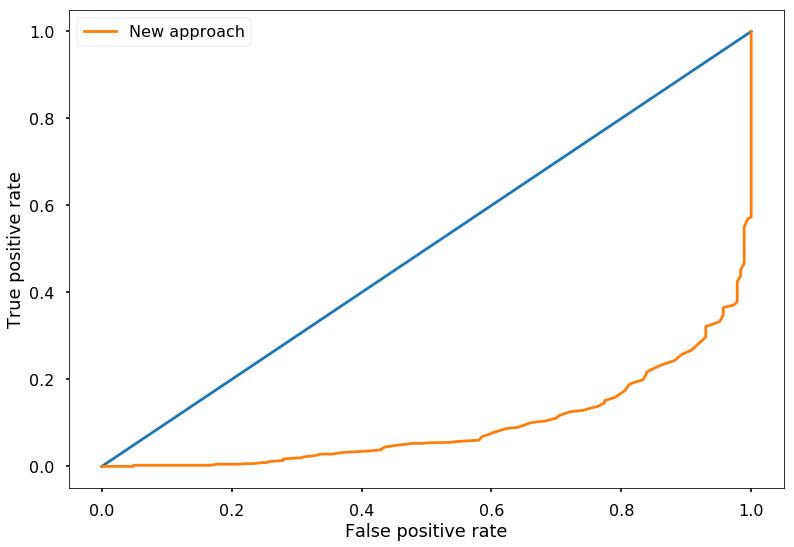

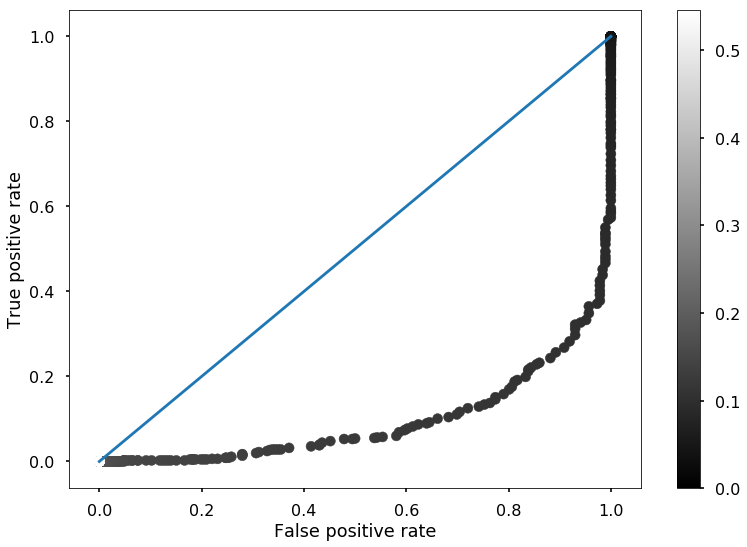

CPU times: user 34 s, sys: 412 ms, total: 34.4 s
Wall time: 35.2 s


In [8]:
%%time

ITERATIONS = 100
CP_PROB = 0.8
IS_MULTIPLICATIVE = False
WINDOW = 24
IS_TREND = False
CHANGE_TYPE = 'local'
APPROACH = 'approximation_mean'
CHANGE_POINT = 396

threshold_list = get_threshold_list(iterations = ITERATIONS,
                                    approach = APPROACH,
                                    window = WINDOW, 
                                    cp_prob = CP_PROB, 
                                    is_multiplicative = IS_MULTIPLICATIVE, 
                                    is_trend = IS_TREND, 
                                    change_type = CHANGE_TYPE,                         
                                    change_point = CHANGE_POINT
                                   )

actual, predicted, thresholds = [], [], []
actual, predicted, thresholds = cp_detection_modeling(iterations = ITERATIONS, 
                                              approach = APPROACH,
                                              _window = WINDOW,
                                              _cp_prob = CP_PROB,
                                              _is_multiplicative = IS_MULTIPLICATIVE,
                                              threshold_list = threshold_list,
                                              _is_trend = IS_TREND, 
                                              _change_type = CHANGE_TYPE,
                                              mode = 'change_end',
                                              change_point = CHANGE_POINT
                                                       )

# df_cp = pd.DataFrame({'actual': actual, 'predicted': predicted, 'threshold': thresholds})

precision = []
recall = []
specificity = []
average_delay = []
precision_filter = []
# test = []
for tr in threshold_list:
    cp_result = confusion_matrix(
                    (np.isnan(actual[thresholds == tr]) == False)*1,
                    (np.isnan(predicted[thresholds == tr]) == False)*1
                )
#     cp_result = cp_quality(df_cp.loc[df_cp['threshold'] == tr, 'actual'], 
#                            df_cp.loc[df_cp['threshold'] == tr, 'predicted']
#                           )
    if sum(cp_result[:,1]) == 0:
        precision.append(1)
    else:
        precision.append(cp_result[1,1]/sum(cp_result[:,1]))

    if sum(cp_result[1,:]) == 0:
        recall.append(1)
    else:
        recall.append(cp_result[1,1]/sum(cp_result[1,:]))

    if sum(cp_result[0,:]) == 0:
        specificity.append(1)
    else:
        specificity.append(cp_result[0,0]/sum(cp_result[0,:]))    

#     if cp_result[1]:
#         average_delay.append(np.mean(cp_result[1]))
#         precision_filter.append(True)
#     else:
#         precision_filter.append(False)
    
#     if (recall[-1] >= 0.8) & (recall[-1] <= 0.90):
#         print(cp_result[0])
#         print(confusion_matrix(
#         [(np.isnan(x)==False)*1 for x in df_cp.loc[df_cp['threshold'] == tr, 'actual']],
#         [(np.isnan(x)==False)*1 for x in df_cp.loc[df_cp['threshold'] == tr, 'predicted']]
#         ))
#         print(df_cp.loc[df_cp['threshold'] == tr, 'actual'])
#         print(df_cp.loc[df_cp['threshold'] == tr, 'predicted'])
#         print('Recall: {:,.2f} FPR: {:,.2f} Threshold: {:,.2f} Precision: {:,.2f}'.format(recall[-1], 1-specificity[-1], tr, precision[-1]))
#     test.append(cp_result[0])
unspecificity = [1-x for x in specificity]

unspecificity_sorted, recall_sorted = (list(t) for t in zip(*sorted(zip(unspecificity, recall))))

print('ROC AUC: {}'.format(np.trapz(recall_sorted, unspecificity_sorted)))

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
# plt.plot(unspecificity_sorted, recall_sorted, label='Old approach')
plt.plot(unspecificity_sorted, recall_sorted, label='New approach')
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.legend()
# plt.savefig('./fig/approximation_mean_2_roc.png')
plt.show()

plt.plot(np.linspace(0, 1, 100), np.linspace(0, 1, 100))
plt.scatter(unspecificity, recall, c=threshold_list, s=100, cmap='gray')
plt.colorbar()
plt.ylabel('True positive rate')
plt.xlabel('False positive rate')
plt.show()

In [9]:
actual
# , predicted, thresholds

array([396., 396., 396., ..., 396., 396., 396.])

In [10]:
print(actual.shape)
print(predicted.shape)
print(thresholds.shape)

(1000000,)
(1000000,)
(1000000,)


In [11]:
tr

0.5463211964716281

In [13]:
# actual[thresholds == tr]

In [56]:
(np.isnan(actual[thresholds == tr]) == False)*1

array([0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1])

In [59]:
thresholds

array([0.        , 0.00054042, 0.00108084, ..., 0.53879896, 0.53933938,
       0.5398798 ])

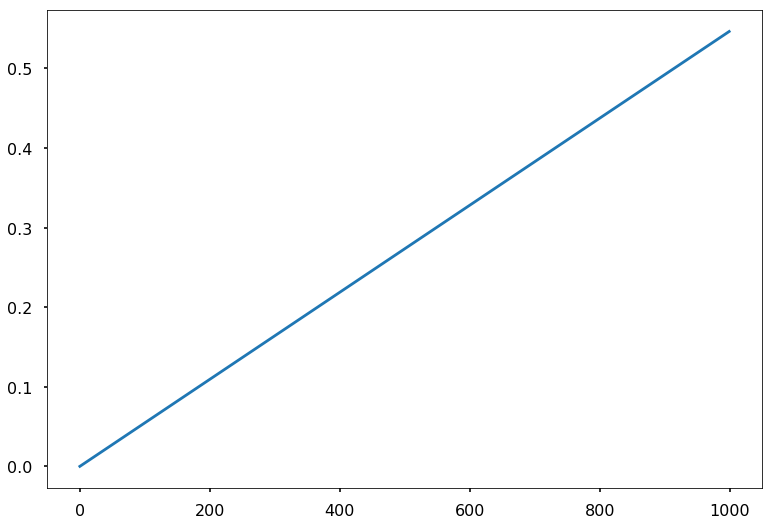

In [14]:
plt.plot(threshold_list)

In [15]:
threshold_list[200]

0.10937361290723287

In [17]:
# (np.isnan(actual[thresholds == threshold_list[200]]) == False)*1

In [70]:
(np.isnan(predicted[thresholds == threshold_list[200]]) == False)*1

array([1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0])

In [18]:
c_m = confusion_matrix((np.isnan(actual[thresholds == threshold_list[200]]) == False)*1,
                 (np.isnan(predicted[thresholds == threshold_list[200]]) == False)*1
                )

print(c_m)
print('Recall: {:,.2f} FPR: {:,.2f}'.format(c_m[1,1]/sum(c_m[1,:]),c_m[0,1]/sum(c_m[0,:])))

[[ 31 155]
 [652 162]]
Recall: 0.20 FPR: 0.83


In [96]:
[i for i in ts_cp if i >= 0.1]

[0.2467287992681177,
 0.12177921214955013,
 0.1314637077120028,
 0.26296395271263,
 0.41247675004015655,
 0.5088517298734754,
 0.5053076972321008,
 0.39889927473539527,
 0.2565540200347361,
 0.12748930985100884,
 0.10868357234799703,
 0.24673941879064246,
 0.3870574538939073,
 0.4982214494816688,
 0.4884347837300501,
 0.39275180086685835,
 0.24970788784498846,
 0.12148054092535183,
 0.11551937907677316,
 0.26906050983681395,
 0.40263856908544726,
 0.5147712170093354,
 0.4910708640998191,
 0.3939492093999551,
 0.2570007429396704,
 0.1263414612942989,
 0.12933169459821722,
 0.27789028255243475,
 0.4152405799069809,
 0.5032701823959285,
 0.4753229606559778,
 0.38099952641346846,
 0.24722614774271384,
 0.11557822907790968,
 0.14954030985620526,
 0.29778384445651207,
 0.4493725623888254,
 0.523221567914559,
 0.5083468936363886,
 0.4024154739642632,
 0.25879908093143755,
 0.11536713254987829,
 0.1542667207420208,
 0.30289485145363687,
 0.46079910718221406,
 0.5393581842024536,
 0.54409336577

True

In [56]:
my_list = []

for i in range(100):
    ts = data_generator(ts_length = 400, 
                       random_seed = None, 
                       cp_prob = 0, 
                       is_multiplicative = False, 
                       is_trend = False, 
                       change_type = 'local',
                       change_point = 396)[0]

    # plt.plot(ts)
    # plt.show()

    ts_cp = approximation_mean(ts, 24)
    
    my_list.append(max(ts_cp[396:]) > 0.1)
    # confusion_matrix(1,1)


my_list_2 = []

for i in range(100):
    ts = data_generator(ts_length = 400, 
                       random_seed = None, 
                       cp_prob = 1, 
                       is_multiplicative = False, 
                       is_trend = False, 
                       change_type = 'local',
                       change_point = 396)[0]

    # plt.plot(ts)
    # plt.show()

    ts_cp = approximation_mean(ts, 24)
    
    my_list_2.append(max(ts_cp[396:]) > 0.1)
    # confusion_matrix(1,1)

# plt.plot(ts_cp[396:])
# plt.show()

In [57]:
print(my_list.count(True), my_list_2.count(True))

96 33


In [28]:
ts_cp[396:]

[0.07822046138034063,
 0.019057071498156147,
 1.0363949068400235e-05,
 0.016608125514491565]

In [23]:
cp_detection(ts_cp, 0.1, 396)

In [24]:
ts_cp[396:]

[0.07822046138034063,
 0.019057071498156147,
 1.0363949068400235e-05,
 0.016608125514491565]

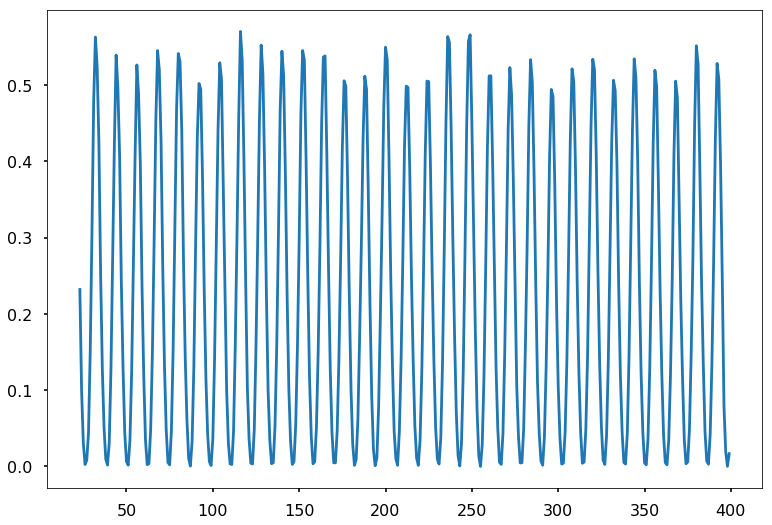

In [25]:
plt.plot(ts_cp)